In [1]:
import numpy as np
import pandas as pd

In [2]:
import textgrids

FRAME_DURATION = 30 # 30 msec
OVERLAP_RATE = 0 # frames don't overlap

def readFile(path):
    '''
    Read the file and return the list of SPEECH/NONSPEECH labels for each frame
    '''
        
    labeled_list  = []
    grid = textgrids.TextGrid(path)

    for interval in grid['silences']:
        if interval.text == "-" or interval.text == " ":
            label = 0
        else:
            label = 1
        dur = interval.dur
        dur_msec = dur * 1000 # sec -> msec
        num_frames = int(round(dur_msec /30)) # the audio is divided into 30 msec frames
        print(dur_msec)
        for i in range(num_frames):
            
            labeled_list.append(label)

    return labeled_list

In [3]:
# Function for reading labels from .TextGrig file:
def readLabels(path, sample_rate):
        
    labeled_list  = []
    grid = textgrids.TextGrid(path)

    for interval in grid['silences']:
        if interval.text == "-" or interval.text == " ":
            label = 0
        else:
            label = 1

        dur = interval.dur
        dur_samples = int(np.round(dur * sample_rate)) # sec -> num of samples
        
        for i in range(dur_samples):
            labeled_list.append(label)

    return labeled_list

In [4]:
import os
import librosa

# root = 'Female/TMIT/SA2'
# audio_name = 'FF482278-24C9-4FB0-A7BE-FD92D1FE17B4-1430028319-1.0-m-26-hu.wav'
# annotation_name = 'FF482278-24C9-4FB0-A7BE-FD92D1FE17B4-1430028319-1_0-m-26-hu.TextGrid'
# audio_path = os.path.join('/home/benjamin.lambright/Desktop/ugrip/Datasets_to_sort/hungry', audio_name)
# annotation_path = os.path.join('/home/benjamin.lambright/Desktop/ugrip/Datasets_to_sort/hungry', annotation_name)

annotation_path = "/home/benjamin.lambright/Desktop/ugrip/Datasets_to_sort/master_annotations/0a983cd2-0078-4698-a048-99ac01eb167a-1433917038889-1.7-f-04-hu.wav.TextGrid"
audio_path = "/home/benjamin.lambright/Desktop/ugrip/Datasets_to_sort/no_subdirectories/0a983cd2-0078-4698-a048-99ac01eb167a-1433917038889-1.7-f-04-hu.wav"

# Read annotation
label_list = readFile(annotation_path)
# Read wav file
data, fs = librosa.load(audio_path)

376.00000000000006
120.0
176.0
6168.0


In [5]:
# define time axis
Ns = len(data)  # number of sample
Ts = 1 / fs  # sampling period
t = np.arange(Ns) * 1000 * Ts  # time axis


shift = 1 - OVERLAP_RATE
frame_length = int(np.floor(FRAME_DURATION * fs / 1000)) # frame length in sample
frame_shift = round(frame_length * shift) # frame shift in sample

IndexError: index 151368 is out of bounds for axis 0 with size 150822

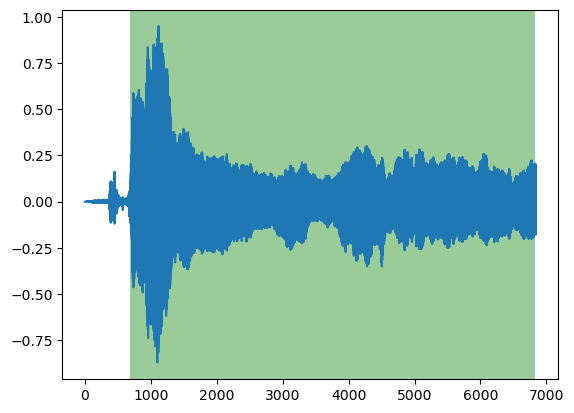

In [6]:
import matplotlib.pyplot as plt

figure = plt.Figure(figsize=(10, 7), dpi=85)
plt.plot(t, data)

for i, frame_labeled in enumerate(label_list):
    idx = i * frame_shift
    if (frame_labeled == 1):
        plt.axvspan(xmin= t[idx], xmax=t[idx + frame_length-1], ymin=-1000, ymax=1000, alpha=0.4, zorder=-100, facecolor='g', label='Speech')

plt.title("Ground truth labels")
plt.legend(['Signal', 'Speech'])
plt.show()

In [7]:
# Preparation
import python_speech_features
from tqdm import tqdm 
from sklearn import model_selection, preprocessing, metrics
# from keras.models import Model
# import keras.layers
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

In [8]:
# Function for getting all files in directories and sub-directories woth definite extension
def getFiles(path, extension):
    list_paths = list()
    for root, dirs, files in os.walk(path):
        for file in files:
            if(file.endswith(extension)):
                list_paths.append(os.path.join(root, file))
    return list_paths

In [9]:
annotation_path = '/home/benjamin.lambright/Desktop/ugrip/Datasets_to_sort/master_annotations'
annotation_extension = '.TextGrid'
audio_path = '/home/benjamin.lambright/Desktop/ugrip/Datasets_to_sort/no_subdirectories'
audio_extension = '.wav'

annotation_files = getFiles(path=annotation_path, extension=annotation_extension)
audio_files = getFiles(path=audio_path, extension=audio_extension)
annotation_files = sorted(annotation_files)
audio_files = sorted(audio_files)

In [10]:
# Processing files

# Set params for Mel-Frequency Cepstral Coefficient (MFCC)
# preemphasis_coef (Pre-emphasis coefficient): The coefficient is used in a preemphasis filter applied to the audio signal before further processing. A value close o 1 emphasis higher frequencies, compensating for the natural roll-off of high frequencies in audio signals
# frame_length: The length of time each window will be when the signal is segmented into frames. (Normally ranged between 20 to 30 milliseconds)
# fram_step: The time window shifted between frames.
# window_function: Applied to each frame to reduce spectral leakage from outside the frame. Hamming window is commonly used
# num_nfft (Number of points for FFT): The number of points used in the Fast Fourier Transform when converting each frame from the time domain to the frequency domain. Large FFT size allow for more precise frequency resolution but also increased computation time.
# num_features (Number of Mel filters): The number of Mel-frequency bins used in the MFCC.

# Mel scale is a way of representing frequencies in a manner similar to human perception. By using Mel filters, the features capture the psychoacoustic properties of the sound.

preemphasis_coef = 0.97 
frame_length = 0.025 
frame_step = 0.01
window_function = np.hamming
num_nfft = 512 
num_features = 32 

In [11]:
len(audio_files)

457

In [12]:
import librosa

# Extraction features for each file:
for i in tqdm(range(len(audio_files))):
    sig, sample_rate = librosa.load(audio_files[i])
    markers = readLabels(path=annotation_files[i], sample_rate=sample_rate)

    # Extract features:
    # features_fbank (Mel-frequency cepstral coefficiens): captures the spectral information of the audio signal in a way that mimics human auditory perception
    # feature_energy: the overall energy of the audio signal within a specific frequency range
    features_fbank, feature_energy  = python_speech_features.base.fbank(signal=sig, 
                                                                        samplerate=sample_rate, 
                                                                        winlen=frame_length, 
                                                                        winstep=frame_step, 
                                                                        nfilt=num_features, 
                                                                        nfft=num_nfft, 
                                                                        lowfreq=0, 
                                                                        highfreq=None, 
                                                                        preemph=preemphasis_coef, 
                                                                        winfunc=window_function)
    # Logfbank and log energy:
    features_logfbank = np.log(features_fbank)
    feature_logenergy = np.log(feature_energy)
    # print('Shape logfbank:', features_fbank.shape)
    # print('Shape logenergy:', feature_logenergy.shape)

    # Merge logfbank and log energy:
    features = np.hstack((feature_logenergy.reshape(feature_logenergy.shape[0], 1), features_logfbank))
    # print('Shape features:', features.shape)

    # Reshape labels for each group of features:
    markers_of_frames = python_speech_features.sigproc.framesig(sig=markers, 
                                                                frame_len=frame_length * sample_rate, 
                                                                frame_step=frame_step * sample_rate, 
                                                                winfunc=np.ones)
    # print('Shape markers_of_frame:', markers_of_frames.shape)
    # For every frame calc label:
    # For every frame calc label:
    marker_per_frame = np.zeros(markers_of_frames.shape[0])
    marker_per_frame = np.array([1 if np.sum(markers_of_frames[j], axis=0) > markers_of_frames.shape[0] / 2 else 0 for j in range(markers_of_frames.shape[0])])
    marker_per_frame = np.zeros(markers_of_frames.shape[0])
    marker_per_frame = np.array([1 if np.sum(markers_of_frames[j], axis=0) > markers_of_frames.shape[0] / 2 else 0 for j in range(markers_of_frames.shape[0])])

    # Create massive for stacking features in first step:
    if i == 0:
        dataset_tmp = np.zeros((1, num_features + 2))

    # Check indices of features and labels:
    restrictive_index = np.min([features.shape[0], marker_per_frame.shape[0]], axis=0)
    features_tmp = features[:restrictive_index]
    marker_per_frame_tmp = marker_per_frame[:restrictive_index]
    
    # Merge label and franes and all frames in dataset:
    dataset_tmp = np.vstack((dataset_tmp, np.hstack((marker_per_frame_tmp.reshape(marker_per_frame_tmp.shape[0], 1), features_tmp))))

100%|██████████| 457/457 [00:31<00:00, 14.31it/s]


In [13]:
# Delete row consist of zeros:
dataset = dataset_tmp[1:]

In [14]:
# Preparation of data
# Split dataset on train and test:
X = dataset[:, 1:]
y = dataset[:, 0]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, shuffle=True, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Scale data:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape datasets to 1 x 300 x num_features:
# So, each group need to consist of 300 frames:
n_frames = 300
X_train_reshaped = X_train[:int(X_train.shape[0] / n_frames) * n_frames]
X_train_reshaped = X_train_reshaped.reshape(int(X_train_reshaped.shape[0] / n_frames), n_frames, X_train_reshaped.shape[1])
X_test_reshaped = X_test[:int(X_test.shape[0] / n_frames) * n_frames]
X_test_reshaped = X_test_reshaped.reshape(int(X_test_reshaped.shape[0] / n_frames), n_frames, X_test_reshaped.shape[1])

(210915, 33) (103884, 33) (210915,) (103884,)


In [15]:
# Encoding label:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

y_train_reshaped = y_train[:int(y_train.shape[0] / n_frames) * n_frames]
y_train_reshaped = y_train_reshaped.reshape(int(y_train_reshaped.shape[0] / n_frames), n_frames, y_train_reshaped.shape[1])
y_test_reshaped = y_test[:int(y_test.shape[0] / n_frames) * n_frames]
y_test_reshaped = y_test_reshaped.reshape(int(y_test_reshaped.shape[0] / n_frames), n_frames, y_test_reshaped.shape[1])

In [16]:
X_train_reshaped.shape

(703, 300, 33)

In [17]:
y_train_reshaped.shape

(703, 300, 2)

In [18]:
# Define the cosine decay parameters
initial_learning_rate = 0.01
decay_steps = 10000

# # Define the model
# class MyModel(nn.Module):
#     def __init__(self, n_frames, num_features):
#         super(MyModel, self).__init__()
#         self.token_embedding = nn.Embedding(1000, 64)
#         self.cnn_layer = nn.Conv1d(in_channels=n_frames*(num_features+1), out_channels=100, kernel_size=4, padding='same')
#         self.attention = nn.MultiheadAttention(embed_dim=64, num_heads=1)
#         self.global_pooling = nn.AdaptiveAvgPool1d(1)
#         self.dense1 = nn.Linear(128, 64)
#         self.dense2 = nn.Linear(64, 300*2)

#     def forward(self, query_input, value_input):
#         query_input_reshaped = query_input.view(-1, query_input.size(1) * (query_input.size(2) + 1))
#         value_input_reshaped = value_input.view(-1, value_input.size(1) * (value_input.size(2) + 1))
#         query_embedding = self.token_embedding(query_input_reshaped)
#         value_embedding = self.token_embedding(value_input_reshaped)
#         query_seq_encoding = self.cnn_layer(query_embedding.permute(0, 2, 1))
#         value_seq_encoding = self.cnn_layer(value_embedding.permute(0, 2, 1))
#         qv_attention_seq, _ = self.attention(query_seq_encoding.permute(1, 0, 2), value_seq_encoding.permute(1, 0, 2))
#         query_encoding = self.global_pooling(query_seq_encoding.permute(0, 2, 1)).squeeze()
#         qv_attention = self.global_pooling(qv_attention_seq.permute(0, 2, 1)).squeeze()
#         input_layer = torch.cat((query_encoding, qv_attention), dim=1)
#         dense_layer1 = nn.functional.relu(self.dense1(input_layer))
#         dense_layer2 = nn.functional.relu(self.dense2(dense_layer1))
#         output_layer_reshaped = dense_layer2.view(-1, 300, 2)
#         return output_layer_reshaped

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, n_heads=2, hidden_dim=64, num_layers=2, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=n_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.embedding(x)
        
        # Permute dimensions for Transformer input
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, hidden_dim)
        
        # Transformer Encoder
        x = self.transformer_encoder(x)
        
        # Permute dimensions back
        x = x.permute(1, 0, 2)  # (batch_size, seq_len, hidden_dim)
        
        # Apply final linear layer
        x = self.fc(x)
        
        return x

In [96]:
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Define input and output dimensions
input_dim = 33
output_dim = 2

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
model = TransformerModel(input_dim=input_dim, output_dim=output_dim).to(device)

# Define input and output data
target_tensor = torch.tensor(y_train_reshaped, dtype=torch.float).to(device)
query_input_tensor = torch.tensor(X_train_reshaped, dtype=torch.float).to(device)
# input_data = torch.randn(587, 300, input_dim)

# loss function and optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

# define cosine decay
T_0 = 10  # Initial number of epochs for the first restart
T_mult = 2  # Multiplicative factor by which the number of epochs for every subsequent restarts increases
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)

# epoch num
num_epochs = 20

for epoch in range(num_epochs):
    # Forward pass
    output = model(query_input_tensor)

    # Compute the loss
    loss = criterion(output, target_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # update the learning rate
    scheduler.step()

    # Print loss for monitoring
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Optionally, calculate and print accuracy
    with torch.no_grad():
        predicted_labels = torch.argmax(output, dim=-1)
        target_labels = torch.argmax(target_tensor, dim=-1)
        accuracy = accuracy_score(target_labels.view(-1).cpu().numpy(), predicted_labels.view(-1).cpu().numpy())
        print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}')


/home/benjamin.lambright/.conda/envs/ugrip/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Loss: 0.6605
Epoch [1/20], Accuracy: 0.8123
Epoch [2/20], Loss: 0.8285
Epoch [2/20], Accuracy: 0.6899
Epoch [3/20], Loss: 0.6853
Epoch [3/20], Accuracy: 0.8128
Epoch [4/20], Loss: 0.5469
Epoch [4/20], Accuracy: 0.8156
Epoch [5/20], Loss: 0.5195
Epoch [5/20], Accuracy: 0.8206
Epoch [6/20], Loss: 0.4917
Epoch [6/20], Accuracy: 0.8282
Epoch [7/20], Loss: 0.4786
Epoch [7/20], Accuracy: 0.8305
Epoch [8/20], Loss: 0.4710
Epoch [8/20], Accuracy: 0.8318
Epoch [9/20], Loss: 0.4665
Epoch [9/20], Accuracy: 0.8325
Epoch [10/20], Loss: 0.4647
Epoch [10/20], Accuracy: 0.8328
Epoch [11/20], Loss: 0.4634
Epoch [11/20], Accuracy: 0.8334
Epoch [12/20], Loss: 0.4380
Epoch [12/20], Accuracy: 0.8426
Epoch [13/20], Loss: 0.4284
Epoch [13/20], Accuracy: 0.8507
Epoch [14/20], Loss: 0.4366
Epoch [14/20], Accuracy: 0.8499
Epoch [15/20], Loss: 0.4409
Epoch [15/20], Accuracy: 0.8523
Epoch [16/20], Loss: 0.4399
Epoch [16/20], Accuracy: 0.8532
Epoch [17/20], Loss: 0.4339
Epoch [17/20], Accuracy: 0.854

In [97]:
from sklearn.metrics import confusion_matrix

# getting the labels in order to compute the confusion matrix
predicted_labels = torch.argmax(output, dim=-1)
target_labels = torch.argmax(target_tensor, dim=-1)

# making these labels numpy arrays
numpy_target_labels = target_labels.view(-1).cpu().numpy()
numpy_predicted_labels = predicted_labels.view(-1).cpu().numpy()

conf_matrix = confusion_matrix(numpy_target_labels, numpy_predicted_labels)
conf_matrix

array([[83379, 12676],
       [17585, 97260]])

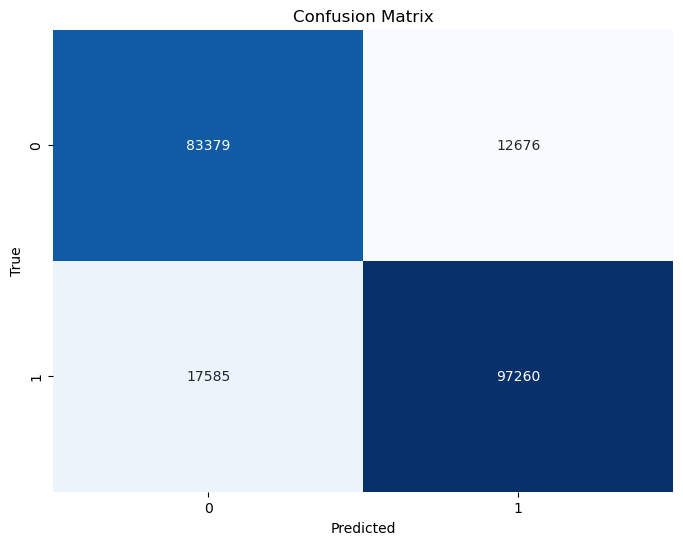

In [98]:
# plottin confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [99]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(numpy_target_labels, numpy_predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(numpy_target_labels, numpy_predicted_labels, average='weighted')

# Calculate F1-score
f1 = f1_score(numpy_target_labels, numpy_predicted_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.8578851624724996
Recall: 0.8565149359886202
F1-score: 0.856735712452335


In [100]:
# # Check if GPU is available, otherwise use CPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Initialize the model
# model = MyModel(n_frames, num_features).to(device)

# # Define the optimizer and scheduler
# optimizer = optim.AdamW(model.parameters(), lr=initial_learning_rate)
# scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=decay_steps)

# # Define the loss function
# criterion = nn.BCEWithLogitsLoss()

# # Convert inputs and outputs to PyTorch tensors
# query_input_tensor = torch.tensor(X_train_reshaped, dtype=torch.long)
# value_input_tensor = torch.tensor(X_train_reshaped, dtype=torch.long)
# target_tensor = torch.tensor(y_train_reshaped, dtype=torch.float)

In [101]:
# query_input_tensor.shape

In [102]:
# target_tensor.shape

In [103]:
# # Training loop
# num_epochs = 10
# num_classes = 2
# for epoch in range(num_epochs):
#     # Forward pass
#     outputs = model(query_input_tensor)
#     loss = criterion(outputs, target_tensor)
    
#     # Backward pass and optimization
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     # Update learning rate
#     scheduler.step()

#     # Print loss for monitoring
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [104]:
# Build Model

# Input(shape=(n_frames, num_features + 1))
# query_input = Input(shape=(n_frames, num_features + 1))
# value_input = Input(shape=(n_frames, num_features + 1))
# token_embedding = Embedding(input_dim=1000, output_dim=64)
# query_embedding = token_embedding(query_input)
# value_embedding = token_embedding(value_input)
# query_seq_encoding = Conv2D(query_embedding)
# value_seq_encoding = Conv2D(value_embedding)
# attention_layer = Attention()([query_seq_encoding, value_seq_encoding])
# output_layer = TimeDistributed(Dense(2, activation='sigmoid'))(BLSTM_2_layer)
# model = Model(inputs=input_layer, outputs=output_layer)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# query_input = keras.layers.Input(shape=(n_frames, num_features + 1))
# value_input = keras.layers.Input(shape=(n_frames, num_features + 1))
# # these inputs won't work for the embedding unless if we reshape them, so I added that
# query_input_reshaped = keras.layers.Reshape((n_frames * (num_features + 1),))(query_input)
# value_input_reshaped = keras.layers.Reshape((n_frames * (num_features + 1),))(value_input)
# # plugging into embeddings
# token_embedding = keras.layers.Embedding(input_dim=1000, output_dim=64)
# query_embedding = token_embedding(query_input_reshaped)
# value_embedding = token_embedding(value_input_reshaped)
# # do a CNN layer
# cnn_layer = keras.layers.Conv1D(filters=100, kernel_size=4, padding='same')  # using padding 
# query_seq_encoding = cnn_layer(query_embedding)
# value_seq_encoding = cnn_layer(value_embedding)
# # plug into attention model, ensure that shape remains the same
# qv_attention_seq = keras.layers.Attention()([query_seq_encoding, value_seq_encoding])
# query_encoding = keras.layers.GlobalAveragePooling1D(keepdims=True)(query_seq_encoding)
# qv_attention = keras.layers.GlobalAveragePooling1D(keepdims=True)(qv_attention_seq)
# input_layer = keras.layers.Concatenate()([query_encoding, qv_attention])
# # linear layers
# dense_layer1 = keras.layers.Dense(units=128, activation='relu')(input_layer)
# dense_layer2 = keras.layers.Dense(units=64, activation='relu')(dense_layer1)
# # output
# output_layer = keras.layers.Dense(units=300*2, activation='softmax')(dense_layer2)  # maybe change the activation cause we don't need softmax for binary classification?
# output_layer_reshaped = keras.layers.Reshape((300, 2))(output_layer)
# model = keras.Model(inputs=[query_input, value_input], outputs=output_layer_reshaped)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [105]:
import matplotlib.pyplot as plt 

def plot_loss(history):
    plt.figure(figsize=(24, 6))
    plt.plot(history.history['loss'], c ="darkblue")
    plt.plot(history.history['val_loss'], c ="crimson")
    plt.legend(["Train", "Validation"])
    plt.title("Model loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, alpha = 0.2)
    plt.show()


def plot_accuracy(history):
    plt.figure(figsize=(24, 6))
    plt.plot(history.history['accuracy'], c ="darkblue")
    plt.plot(history.history['val_accuracy'], c ="crimson")
    plt.legend(["Train", "Validation"])
    plt.title("Model accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha = 0.2)
    plt.show()

In [106]:

# import tensorflow as tf
# print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))




In [107]:
# history = model.fit(x=[X_train_reshaped, X_train_reshaped], y=y_train_reshaped, validation_data=([X_test_reshaped, X_test_reshaped], y_test_reshaped), epochs=25, batch_size=64)

In [108]:
# figure out how to plot the loss and accuracy over time

# plot_loss(history)
# plot_accuracy(history)

In [109]:
annotation_file = "/home/benjamin.lambright/Desktop/ugrip/Datasets_to_sort/master_annotations/8c920fd0-fa9f-4926-bcac-074767dcbfcd-1436850948195-1.7-m-04-hu.wav.TextGrid"
audio_file = "/home/benjamin.lambright/Desktop/ugrip/Datasets_to_sort/no_subdirectories/8c920fd0-fa9f-4926-bcac-074767dcbfcd-1436850948195-1.7-m-04-hu.wav"

# Load samples:
input_signal, fs = librosa.load(audio_file)


# Load labels:
truth_labels = readLabels(path=annotation_file, sample_rate=fs)

# Extract features:
features_fbank_valid, feature_energy_valid  = python_speech_features.base.fbank(signal=input_signal, samplerate=fs, winlen=frame_length, winstep=frame_step, 
                                                                                nfilt=num_features, nfft=num_nfft, lowfreq=0, highfreq=None, preemph=preemphasis_coef, 
                                                                                winfunc=window_function)

# Logfbank and log energy:
features_logfbank_valid = np.log(features_fbank_valid)
feature_logenergy_valid = np.log(feature_energy_valid)

# Merge logfbank and log energy:
features_valid = np.hstack((feature_logenergy_valid.reshape(feature_logenergy_valid.shape[0], 1), features_logfbank_valid))

# Reshape labels for each group of features:
markers_of_frames_truth = python_speech_features.sigproc.framesig(sig=truth_labels, frame_len=frame_length * fs, frame_step=frame_step * fs, winfunc=np.ones)

# For every frame calc label:
marker_per_frame_truth = np.zeros(markers_of_frames_truth.shape[0])
marker_per_frame_truth = np.array([1 if np.sum(markers_of_frames_truth[j], axis=0) > markers_of_frames_truth.shape[0] / 2 else 0 
                                   for j in range(markers_of_frames_truth.shape[0])])

# Check indices of features and labels:
restrictive_index = np.min([features_valid.shape[0], markers_of_frames_truth.shape[0]], axis=0)
features_valid_tmp = features_valid[:restrictive_index]
marker_per_frame_truth_tmp = marker_per_frame_truth[:restrictive_index]

In [110]:
# Split label and features:
X_valid = features_valid_tmp;
y_truth = marker_per_frame_truth_tmp

# Scaling:
X_valid = scaler.transform(X_valid)

# Reshape datasets to 1 x 300 x num_features:
if X_valid.shape[0] < n_frames:
    added_frames = np.zeros((n_frames - X_valid.shape[0], X_valid.shape[1]))
    add_labels = np.zeros(n_frames - X_valid.shape[0])
    X_valid = np.vstack((X_valid, added_frames))
    y_truth = np.hstack((y_truth, add_labels))
X_valid_reshaped = X_valid[:int(X_valid.shape[0] / n_frames) * n_frames]
X_valid_reshaped = X_valid_reshaped.reshape(int(X_valid_reshaped.shape[0] / n_frames), n_frames, X_valid_reshaped.shape[1])

In [111]:
# convert it to numpy array
valid_input = torch.tensor(X_valid_reshaped, dtype=torch.float).to(device)

# predict
model.eval()
with torch.no_grad():
    prediction = model.forward(valid_input)

predicted_label = np.zeros(prediction.shape[0] * prediction.shape[1])
predicted_proba = np.zeros(prediction.shape[0] * prediction.shape[1])
ind = 0
for i in range(prediction.shape[0]):
    for j in range(prediction.shape[1]):
        if prediction[i][j][0] >= prediction[i][j][1]:
            predicted_label[ind] = 0
            predicted_proba[ind] = prediction[i][j][0]
        else:
            predicted_label[ind] = 1
            predicted_proba[ind] = prediction[i][j][1]
        ind = ind + 1
        
predicted_label

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [112]:
label_timeseries = np.zeros(input_signal.shape[0])
begin = int(0)
end = int(frame_length * fs)
shift_step = int(frame_step * fs)
for i in range(predicted_label.shape[0]):
    label_timeseries[begin:end] = predicted_label[i]
    begin = begin + shift_step
    end = end + shift_step

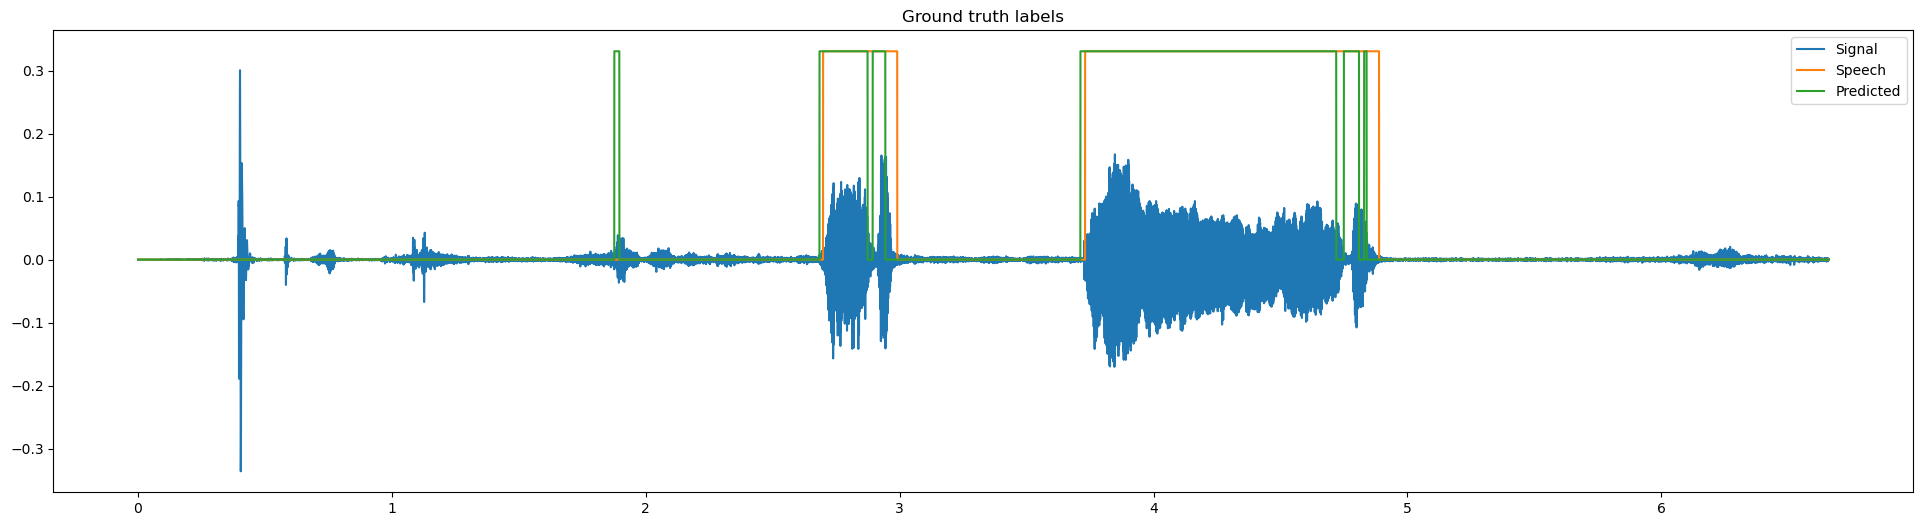

In [113]:
# define time axis
Ns = len(input_signal)  # number of sample
Ts = 1 / fs  # sampling period
t = np.arange(Ns) * Ts  # time axis in seconds
norm_coef = 1.1 * np.max(input_signal)

edge_ind = np.min([input_signal.shape[0], len(truth_labels)])

plt.figure(figsize=(24, 6))
plt.plot(t[:edge_ind], input_signal[:edge_ind])
plt.plot(t[:edge_ind], np.array(truth_labels[:edge_ind]) * norm_coef)
plt.plot(t[:edge_ind], label_timeseries[:edge_ind] * norm_coef)

plt.title("Ground truth labels")
plt.legend(['Signal', 'Speech', 'Predicted'])
plt.show()

In [114]:
import metrics

# predicted_labels = label_timeseries[:-1]

segment_metrics = metrics.segment_metrics(truth_labels, label_timeseries, 100)
(segment_metrics["true_positive"], segment_metrics["false_positive"], segment_metrics["false_negative"])

(20, 0, 2)

In [115]:
len(truth_labels), len(label_timeseries)

(146853, 146853)

In [116]:
segment_metrics["f_score"]

0.9523809523809523

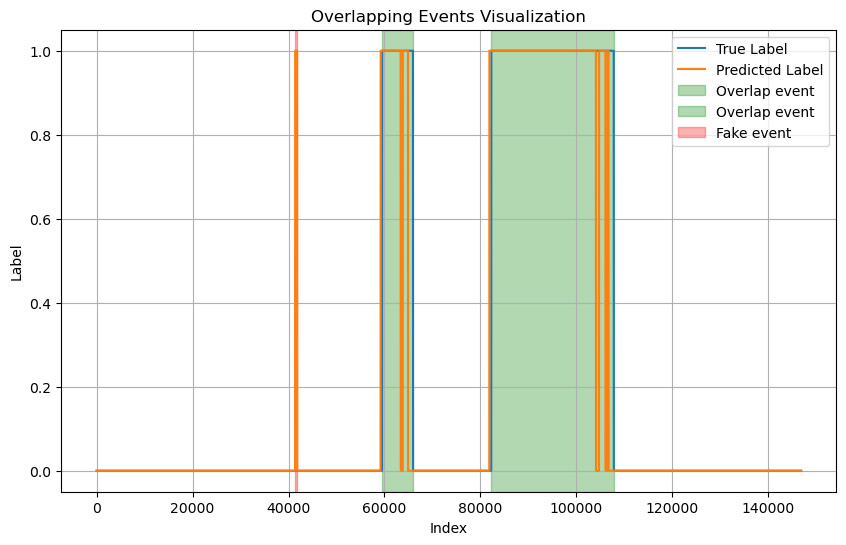

In [117]:
event_metrics = metrics.event_metrics(truth_labels, label_timeseries, tolerance=2000, overlap_threshold=0.75)
metrics.event_visualization(truth_labels, label_timeseries, event_metrics['counted_events'], event_metrics['fake_events'], event_metrics['undetected_events'])

In [118]:
(event_metrics["true_positive"], event_metrics["false_positive"], event_metrics["false_negative"])

(2, 1, 0)

In [119]:
event_metrics["f_score"]

0.8